# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import os

### Importar a base de dados

In [2]:
# Foi utilizada a base de dados de cotação de ações da Petrobras (PETR4)
# O período analisado vai de 23/05/2020 a 23/05/2023
# A série temporal foi dividida em treino (30%) e teste (70%)

In [3]:
PETR4_data = pd.read_csv('PETR4.csv')

In [4]:
PETR4_data_train = PETR4_data.iloc[1:249, 0:2].values

In [5]:
PETR4_data_test= PETR4_data.iloc[249:747, 0:2].values

In [6]:
training_set = PETR4_data.iloc[0:249, 1:2].values

In [7]:
test_set = PETR4_data.iloc[249:747,1:2]

### Parâmetros para esta análise

In [8]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [10]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [11]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [15]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 15, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 80)            57920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

### Treinamento

In [16]:
history = regressor.fit(X_train, y_train, epochs = pepochs1, batch_size = pbatch1)

Epoch 1/25
8/8 [==============================] - 0s 57ms/step - loss: 0.0535
Epoch 2/25
8/8 [==============================] - 1s 69ms/step - loss: 0.0315
Epoch 3/25
8/8 [==============================] - 1s 90ms/step - loss: 0.0230
Epoch 4/25
8/8 [==============================] - 1s 89ms/step - loss: 0.0208
Epoch 5/25
8/8 [==============================] - 1s 90ms/step - loss: 0.0183
Epoch 6/25
8/8 [==============================] - 1s 89ms/step - loss: 0.0215
Epoch 7/25
8/8 [==============================] - 1s 89ms/step - loss: 0.0196
Epoch 8/25
8/8 [==============================] - 1s 89ms/step - loss: 0.0148
Epoch 9/25
8/8 [==============================] - 1s 90ms/step - loss: 0.0167
Epoch 10/25
8/8 [==============================] - 1s 89ms/step - loss: 0.0177
Epoch 11/25
8/8 [==============================] - 1s 89ms/step - loss: 0.0158
Epoch 12/25
8/8 [==============================] - 1s 90ms/step - loss: 0.0143
Epoch 13/25
8/8 [==============================] - 1s 89ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [17]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [18]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [19]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

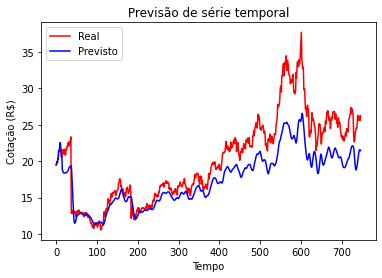

In [20]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [21]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 4.301260670414794


In [22]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 18.50084335485712


In [23]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 14.952970102683242 %


In [24]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.24714024047271477


In [25]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.24562237805431297


In [26]:
results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [27]:
# data = pd.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2])

In [28]:
# results = np.column_stack((results, data))

In [29]:
print(results)

[15.         25.         32.          4.30126067 18.50084335 14.9529701
  0.24714024  0.24562238]


### Parâmetros para esta análise

In [30]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [31]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [32]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [33]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [34]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [35]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [37]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 100)           40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 80)            57920     
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 80)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### Treinamento

In [38]:
history = regressor.fit(X_train, y_train, epochs = pepochs1, batch_size = pbatch2)

Epoch 1/25
4/4 [==============================] - 0s 74ms/step - loss: 0.0869
Epoch 2/25
4/4 [==============================] - 0s 78ms/step - loss: 0.0304
Epoch 3/25
4/4 [==============================] - 0s 70ms/step - loss: 0.0232
Epoch 4/25
4/4 [==============================] - 0s 75ms/step - loss: 0.0242
Epoch 5/25
4/4 [==============================] - 0s 81ms/step - loss: 0.0205
Epoch 6/25
4/4 [==============================] - 0s 76ms/step - loss: 0.0202
Epoch 7/25
4/4 [==============================] - 0s 71ms/step - loss: 0.0196
Epoch 8/25
4/4 [==============================] - 0s 93ms/step - loss: 0.0180
Epoch 9/25
4/4 [==============================] - 0s 77ms/step - loss: 0.0196
Epoch 10/25
4/4 [==============================] - 0s 75ms/step - loss: 0.0179
Epoch 11/25
4/4 [==============================] - 0s 63ms/step - loss: 0.0185
Epoch 12/25
4/4 [==============================] - 0s 61ms/step - loss: 0.0176
Epoch 13/25
4/4 [==============================] - 0s 100ms/s

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [39]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [40]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [41]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

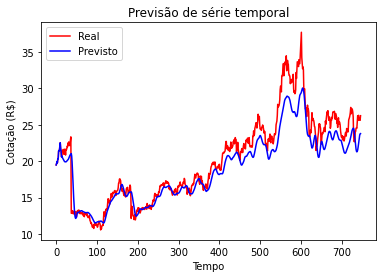

In [42]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [43]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.4347075487723893


In [44]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 5.927800848049255


In [45]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 7.71132348816984 %


In [46]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7587784169949011


In [47]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7582920831581973


In [48]:
# results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [49]:
data = pd.array([pwindow,pepochs1,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2])

In [50]:
results = np.column_stack((results, data))

In [51]:
print(results)

[[15.         15.        ]
 [25.         25.        ]
 [32.         64.        ]
 [ 4.30126067  2.43470755]
 [18.50084335  5.92780085]
 [14.9529701   7.71132349]
 [ 0.24714024  0.75877842]
 [ 0.24562238  0.75829208]]


### Parâmetros para esta análise

In [52]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [53]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [54]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [55]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [56]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [57]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [59]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 15, 100)           40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 80)            57920     
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 80)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

### Treinamento

In [60]:
history = regressor.fit(X_train, y_train, epochs = pepochs1, batch_size = pbatch3)

Epoch 1/25
2/2 [==============================] - 0s 44ms/step - loss: 0.1489
Epoch 2/25
2/2 [==============================] - 0s 43ms/step - loss: 0.0610
Epoch 3/25
2/2 [==============================] - 0s 43ms/step - loss: 0.0222
Epoch 4/25
2/2 [==============================] - 0s 54ms/step - loss: 0.0474
Epoch 5/25
2/2 [==============================] - 0s 66ms/step - loss: 0.0316
Epoch 6/25
2/2 [==============================] - 0s 70ms/step - loss: 0.0214
Epoch 7/25
2/2 [==============================] - 0s 69ms/step - loss: 0.0288
Epoch 8/25
2/2 [==============================] - 0s 67ms/step - loss: 0.0303
Epoch 9/25
2/2 [==============================] - 0s 68ms/step - loss: 0.0266
Epoch 10/25
2/2 [==============================] - 0s 61ms/step - loss: 0.0215
Epoch 11/25
2/2 [==============================] - 0s 50ms/step - loss: 0.0196
Epoch 12/25
2/2 [==============================] - 0s 48ms/step - loss: 0.0211
Epoch 13/25
2/2 [==============================] - 0s 58ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [61]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [62]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [63]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

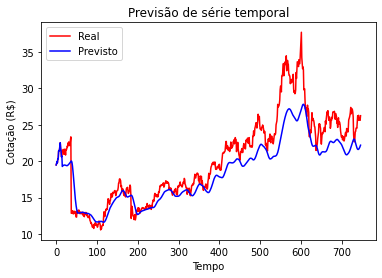

In [64]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [65]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 3.245014463224319


In [66]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 10.530118866535016


In [67]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 10.563051660145092 %


In [68]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.571495060760461


In [69]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.5706311395119942


In [70]:
# results = np.array([pwindow,pepochs1,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [71]:
data = pd.array([pwindow,pepochs1,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [72]:
results = np.column_stack((results, data))

In [73]:
print(results)

[[ 15.          15.          15.        ]
 [ 25.          25.          25.        ]
 [ 32.          64.         128.        ]
 [  4.30126067   2.43470755   3.24501446]
 [ 18.50084335   5.92780085  10.53011887]
 [ 14.9529701    7.71132349  10.56305166]
 [  0.24714024   0.75877842   0.57149506]
 [  0.24562238   0.75829208   0.57063114]]


### Parâmetros para esta análise

In [74]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [75]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [76]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [77]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [78]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [79]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [81]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 100)           40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Treinamento

In [82]:
history = regressor.fit(X_train, y_train, epochs = pepochs2, batch_size = pbatch1)

Epoch 1/50
8/8 [==============================] - 0s 60ms/step - loss: 0.0609
Epoch 2/50
8/8 [==============================] - 1s 86ms/step - loss: 0.0229
Epoch 3/50
8/8 [==============================] - 1s 77ms/step - loss: 0.0244
Epoch 4/50
8/8 [==============================] - 1s 73ms/step - loss: 0.0222
Epoch 5/50
8/8 [==============================] - 1s 64ms/step - loss: 0.0197
Epoch 6/50
8/8 [==============================] - 1s 91ms/step - loss: 0.0210
Epoch 7/50
8/8 [==============================] - 1s 94ms/step - loss: 0.0214
Epoch 8/50
8/8 [==============================] - 1s 89ms/step - loss: 0.0313
Epoch 9/50
8/8 [==============================] - 1s 88ms/step - loss: 0.0199
Epoch 10/50
8/8 [==============================] - 1s 92ms/step - loss: 0.0173
Epoch 11/50
8/8 [==============================] - 1s 91ms/step - loss: 0.0185
Epoch 12/50
8/8 [==============================] - 1s 91ms/step - loss: 0.0146
Epoch 13/50
8/8 [==============================] - 1s 90ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [83]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [84]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [85]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

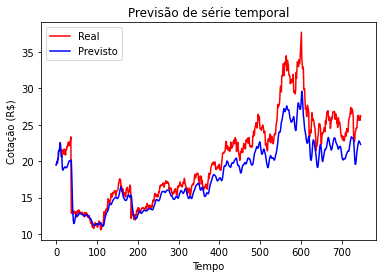

In [86]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [87]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 3.2102828948602933


In [88]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 10.305916265032584


In [89]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 11.264939613240337 %


In [90]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.5806185970995867


In [91]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.5797730700776101


In [92]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [93]:
data = pd.array([pwindow,pepochs2,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2])

In [94]:
results = np.column_stack((results, data))

In [95]:
print(results)

[[ 15.          15.          15.          15.        ]
 [ 25.          25.          25.          50.        ]
 [ 32.          64.         128.          32.        ]
 [  4.30126067   2.43470755   3.24501446   3.21028289]
 [ 18.50084335   5.92780085  10.53011887  10.30591627]
 [ 14.9529701    7.71132349  10.56305166  11.26493961]
 [  0.24714024   0.75877842   0.57149506   0.5806186 ]
 [  0.24562238   0.75829208   0.57063114   0.57977307]]


### Parâmetros para esta análise

In [96]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [97]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [98]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [99]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [100]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [101]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [102]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [103]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Treinamento

In [104]:
history = regressor.fit(X_train, y_train, epochs = pepochs2, batch_size = pbatch2)

Epoch 1/50
4/4 [==============================] - 0s 56ms/step - loss: 0.0778
Epoch 2/50
4/4 [==============================] - 0s 64ms/step - loss: 0.0392
Epoch 3/50
4/4 [==============================] - 0s 87ms/step - loss: 0.0250
Epoch 4/50
4/4 [==============================] - 0s 62ms/step - loss: 0.0301
Epoch 5/50
4/4 [==============================] - 0s 57ms/step - loss: 0.0223
Epoch 6/50
4/4 [==============================] - 0s 58ms/step - loss: 0.0227
Epoch 7/50
4/4 [==============================] - 0s 57ms/step - loss: 0.0216
Epoch 8/50
4/4 [==============================] - 0s 53ms/step - loss: 0.0182
Epoch 9/50
4/4 [==============================] - 0s 52ms/step - loss: 0.0211
Epoch 10/50
4/4 [==============================] - 0s 82ms/step - loss: 0.0192
Epoch 11/50
4/4 [==============================] - 0s 82ms/step - loss: 0.0189
Epoch 12/50
4/4 [==============================] - 0s 82ms/step - loss: 0.0170
Epoch 13/50
4/4 [==============================] - 0s 82ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [105]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [106]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [107]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

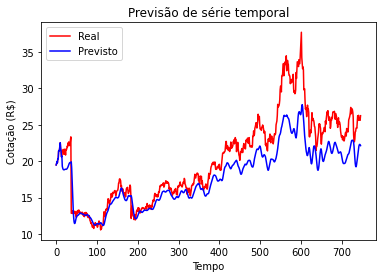

In [108]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [109]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 3.7485373078642894


In [110]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 14.051531948450453


In [111]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 12.817534068673512 %


In [112]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.4281972577794374


In [113]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.4270444296701218


In [114]:
# results = np.array([pwindow,pepochs2,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [115]:
data = pd.array([pwindow,pepochs2,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2])

In [116]:
results = np.column_stack((results, data))

In [117]:
print(results)

[[ 15.          15.          15.          15.          15.        ]
 [ 25.          25.          25.          50.          50.        ]
 [ 32.          64.         128.          32.          64.        ]
 [  4.30126067   2.43470755   3.24501446   3.21028289   3.74853731]
 [ 18.50084335   5.92780085  10.53011887  10.30591627  14.05153195]
 [ 14.9529701    7.71132349  10.56305166  11.26493961  12.81753407]
 [  0.24714024   0.75877842   0.57149506   0.5806186    0.42819726]
 [  0.24562238   0.75829208   0.57063114   0.57977307   0.42704443]]


### Parâmetros para esta análise

In [118]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [119]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [120]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [121]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [122]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [123]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [124]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [125]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Treinamento

In [126]:
history = regressor.fit(X_train, y_train, epochs = pepochs2, batch_size = pbatch3)

Epoch 1/50
2/2 [==============================] - 0s 58ms/step - loss: 0.1356
Epoch 2/50
2/2 [==============================] - 0s 74ms/step - loss: 0.0630
Epoch 3/50
2/2 [==============================] - 0s 74ms/step - loss: 0.0260
Epoch 4/50
2/2 [==============================] - 0s 75ms/step - loss: 0.0439
Epoch 5/50
2/2 [==============================] - 0s 75ms/step - loss: 0.0332
Epoch 6/50
2/2 [==============================] - 0s 74ms/step - loss: 0.0234
Epoch 7/50
2/2 [==============================] - 0s 74ms/step - loss: 0.0281
Epoch 8/50
2/2 [==============================] - 0s 73ms/step - loss: 0.0276
Epoch 9/50
2/2 [==============================] - 0s 76ms/step - loss: 0.0253
Epoch 10/50
2/2 [==============================] - 0s 77ms/step - loss: 0.0209
Epoch 11/50
2/2 [==============================] - 0s 74ms/step - loss: 0.0196
Epoch 12/50
2/2 [==============================] - 0s 75ms/step - loss: 0.0211
Epoch 13/50
2/2 [==============================] - 0s 78ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [127]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [128]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [129]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

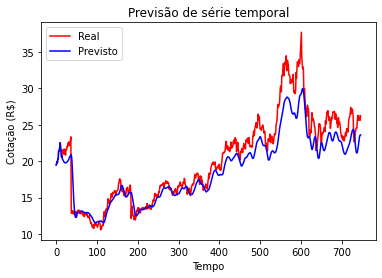

In [130]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [131]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.5498311847237938


In [132]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 6.501639070589945


In [133]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 8.253064215324 %


In [134]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7354270649541776


In [135]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.734893651778682


In [136]:
# results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [137]:
data = pd.array([pwindow,pepochs2,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [138]:
results = np.column_stack((results, data))

In [139]:
print(results)

[[ 15.          15.          15.          15.          15.
   15.        ]
 [ 25.          25.          25.          50.          50.
   50.        ]
 [ 32.          64.         128.          32.          64.
  128.        ]
 [  4.30126067   2.43470755   3.24501446   3.21028289   3.74853731
    2.54983118]
 [ 18.50084335   5.92780085  10.53011887  10.30591627  14.05153195
    6.50163907]
 [ 14.9529701    7.71132349  10.56305166  11.26493961  12.81753407
    8.25306422]
 [  0.24714024   0.75877842   0.57149506   0.5806186    0.42819726
    0.73542706]
 [  0.24562238   0.75829208   0.57063114   0.57977307   0.42704443
    0.73489365]]


### Parâmetros para esta análise

In [140]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [141]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [142]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [143]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [144]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [145]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [146]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [147]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_19 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

### Treinamento

In [148]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch1)

Epoch 1/100
8/8 [==============================] - 0s 58ms/step - loss: 0.0674
Epoch 2/100
8/8 [==============================] - 1s 87ms/step - loss: 0.0277
Epoch 3/100
8/8 [==============================] - 1s 93ms/step - loss: 0.0251
Epoch 4/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0225
Epoch 5/100
8/8 [==============================] - 1s 95ms/step - loss: 0.0225
Epoch 6/100
8/8 [==============================] - 1s 95ms/step - loss: 0.0188
Epoch 7/100
8/8 [==============================] - 1s 66ms/step - loss: 0.0179
Epoch 8/100
8/8 [==============================] - 0s 47ms/step - loss: 0.0179
Epoch 9/100
8/8 [==============================] - 1s 76ms/step - loss: 0.0178
Epoch 10/100
8/8 [==============================] - 1s 70ms/step - loss: 0.0195
Epoch 11/100
8/8 [==============================] - 1s 71ms/step - loss: 0.0168
Epoch 12/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0162
Epoch 13/100
8/8 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [149]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [150]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [151]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

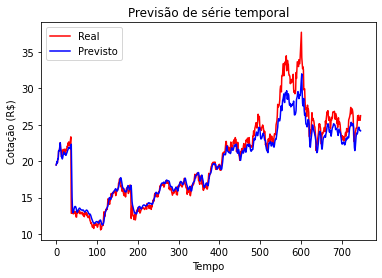

In [152]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [153]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.720330928315699


In [154]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 2.9595385029195542


In [155]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 4.64611913574708 %


In [156]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.8795667093178864


In [157]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.8793239002640918


In [158]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [159]:
data = pd.array([pwindow,pepochs3,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2])

In [160]:
results = np.column_stack((results, data))

In [161]:
print(results)

[[ 15.          15.          15.          15.          15.
   15.          15.        ]
 [ 25.          25.          25.          50.          50.
   50.         100.        ]
 [ 32.          64.         128.          32.          64.
  128.          32.        ]
 [  4.30126067   2.43470755   3.24501446   3.21028289   3.74853731
    2.54983118   1.72033093]
 [ 18.50084335   5.92780085  10.53011887  10.30591627  14.05153195
    6.50163907   2.9595385 ]
 [ 14.9529701    7.71132349  10.56305166  11.26493961  12.81753407
    8.25306422   4.64611914]
 [  0.24714024   0.75877842   0.57149506   0.5806186    0.42819726
    0.73542706   0.87956671]
 [  0.24562238   0.75829208   0.57063114   0.57977307   0.42704443
    0.73489365   0.8793239 ]]


### Parâmetros para esta análise

In [162]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [163]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [164]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [165]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [166]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [167]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [168]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [169]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### Treinamento

In [170]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch1)

Epoch 1/100
8/8 [==============================] - 1s 67ms/step - loss: 0.0710
Epoch 2/100
8/8 [==============================] - 1s 93ms/step - loss: 0.0259
Epoch 3/100
8/8 [==============================] - 1s 93ms/step - loss: 0.0247
Epoch 4/100
8/8 [==============================] - 1s 87ms/step - loss: 0.0207
Epoch 5/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0203
Epoch 6/100
8/8 [==============================] - 1s 93ms/step - loss: 0.0167
Epoch 7/100
8/8 [==============================] - 1s 94ms/step - loss: 0.0173
Epoch 8/100
8/8 [==============================] - 1s 93ms/step - loss: 0.0185
Epoch 9/100
8/8 [==============================] - 1s 94ms/step - loss: 0.0179
Epoch 10/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0180
Epoch 11/100
8/8 [==============================] - 1s 63ms/step - loss: 0.0203
Epoch 12/100
8/8 [==============================] - 1s 87ms/step - loss: 0.0198
Epoch 13/100
8/8 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [171]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [172]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [173]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

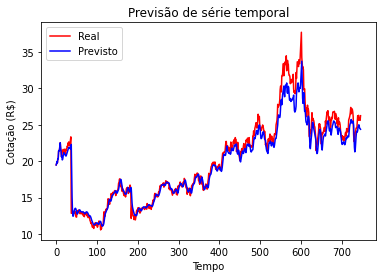

In [174]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [175]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 1.4419059067406164


In [176]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 2.079092643893479


In [177]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 4.108412741614598 %


In [178]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.9153949277936211


In [179]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.9152243530512695


In [180]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [181]:
data = pd.array([pwindow,pepochs3,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2])

In [182]:
results = np.column_stack((results, data))

In [183]:
print(results)

[[ 15.          15.          15.          15.          15.
   15.          15.          15.        ]
 [ 25.          25.          25.          50.          50.
   50.         100.         100.        ]
 [ 32.          64.         128.          32.          64.
  128.          32.          64.        ]
 [  4.30126067   2.43470755   3.24501446   3.21028289   3.74853731
    2.54983118   1.72033093   1.44190591]
 [ 18.50084335   5.92780085  10.53011887  10.30591627  14.05153195
    6.50163907   2.9595385    2.07909264]
 [ 14.9529701    7.71132349  10.56305166  11.26493961  12.81753407
    8.25306422   4.64611914   4.10841274]
 [  0.24714024   0.75877842   0.57149506   0.5806186    0.42819726
    0.73542706   0.87956671   0.91539493]
 [  0.24562238   0.75829208   0.57063114   0.57977307   0.42704443
    0.73489365   0.8793239    0.91522435]]


### Parâmetros para esta análise

In [184]:
pwindow = 15
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [185]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [186]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [187]:
X_train.shape

(234, 15)

Shape de input da lstm = (batch_size, timesteps, features)

In [188]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [189]:
X_train.shape

(234, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [190]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [191]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 15, 80)            57920     
_________________________________________________________________
dropout_25 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

### Treinamento

In [192]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch3)

Epoch 1/100
2/2 [==============================] - 0s 20ms/step - loss: 0.1290
Epoch 2/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0572
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 0.0224
Epoch 4/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0382
Epoch 5/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0284
Epoch 6/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0228
Epoch 7/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0286
Epoch 8/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0281
Epoch 9/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0258
Epoch 10/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0218
Epoch 11/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0195
Epoch 12/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0211
Epoch 13/100
2/2 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [193]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [194]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [195]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

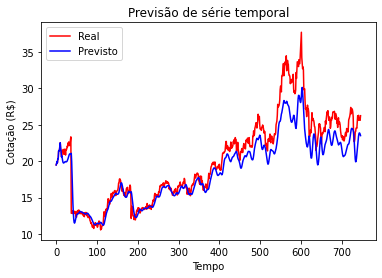

In [196]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [197]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.6669421592769713


In [198]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 7.112580480928915


In [199]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 8.358992580148668 %


In [200]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7105658629834953


In [201]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7099823264169298


In [202]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [203]:
data = pd.array([pwindow,pepochs3,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [204]:
results = np.column_stack((results, data))

In [205]:
print(results)

[[ 15.          15.          15.          15.          15.
   15.          15.          15.          15.        ]
 [ 25.          25.          25.          50.          50.
   50.         100.         100.         100.        ]
 [ 32.          64.         128.          32.          64.
  128.          32.          64.         128.        ]
 [  4.30126067   2.43470755   3.24501446   3.21028289   3.74853731
    2.54983118   1.72033093   1.44190591   2.66694216]
 [ 18.50084335   5.92780085  10.53011887  10.30591627  14.05153195
    6.50163907   2.9595385    2.07909264   7.11258048]
 [ 14.9529701    7.71132349  10.56305166  11.26493961  12.81753407
    8.25306422   4.64611914   4.10841274   8.35899258]
 [  0.24714024   0.75877842   0.57149506   0.5806186    0.42819726
    0.73542706   0.87956671   0.91539493   0.71056586]
 [  0.24562238   0.75829208   0.57063114   0.57977307   0.42704443
    0.73489365   0.8793239    0.91522435   0.70998233]]


In [206]:
my_df = pd.DataFrame(results)

In [207]:
my_df.to_csv('results_LSTM1.csv', index=False)